# Introduction

# Preparatory analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
data = pd.read_csv('data/diabetic_data.csv')

In [3]:
data.rename(columns={'glyburide-metformin':'glyburide_metformin', 'glipizide-metformin': 'glipizide_metformin', 
             'glimepiride-pioglitazone': 'glimepiride_pioglitazone', 'metformin-rosiglitazone': 'metformin_rosiglitazone', 
             'metformin-pioglitazone': 'metformin_pioglitazone'}, inplace=True)

In [4]:
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide_metformin,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


## Counting missing values for each feature

### Nan Values

In [5]:
data.shape

(101766, 50)

In [6]:
na_values = data.isna().sum(axis=0)

print(na_values[na_values > 0]/len(data) * 100)

max_glu_serum    94.746772
A1Cresult        83.277322
dtype: float64


Apparently, max_glu_serum and A1Cresults are the only features with 'Nan' values. We can easily drop these columns, as these features are categorical so they cannot be inferred in any way. 


In [7]:
data['max_glu_serum'].unique()

array([nan, '>300', 'Norm', '>200'], dtype=object)

In [8]:
data['A1Cresult'].unique()

array([nan, '>7', '>8', 'Norm'], dtype=object)

In [9]:
data = data.drop(columns=['max_glu_serum', 'A1Cresult'])

### Other missing values

Taking a look at the datasaet, it is clear that for some features missing values are indicated by a question mark rathen than being nan values. Let's count missing values for each column

In [10]:
for col in data.columns:
    missing_values = data.loc[data[col] == '?', col].value_counts()
    if len(missing_values.values > 0):
        print(col, missing_values.values/len(data) * 100)

race [2.23355541]
weight [96.85847926]
payer_code [39.55741603]
medical_specialty [49.0822082]
diag_1 [0.02063558]
diag_2 [0.35178743]
diag_3 [1.39830592]


From the results above, we find that the feature 'weight' is available only for 3% of the observations! This column can be dropped. We also find that 49% of observations do not have values for medical_speciality and 39% do not have values for payer_code. These two are both categorical variables, so we cannot use the mean or other statistics to replace missing values. So, they can easily be dropped
diag_1, diag_2 and diag_3 are diagnosis so they cannot be inferred. In a classification setting these features can cleary be useful. Suppose the primary diagnosis is correct: intuitevely, a patient with a correct diagnosis has a less probability of returning to the hospital rather than a patient with n incorrect diaagnosis. Rather than drop the columns it is wiser to drop the observations with missing diagnosis.

In [11]:
data = data.drop(columns=['weight', 'payer_code', 'medical_specialty'])

In [12]:
data.shape

(101766, 45)

In [13]:
data.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,citoglipton,insulin,glyburide_metformin,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,41,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,59,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


Data is now ready for the analysis pipeline!

## Renaiming some columns

To avoid potential failure when using statsmodel, we rename the columns that contains a '-' in their name.

In [14]:
data.rename(columns={'glyburide-metformin':'glyburide_metformin', 'glipizide-metformin': 'glipizide_metformin', 
             'glimepiride-pioglitazone': 'glimepiride_pioglitazone', 'metformin-rosiglitazone': 'metformin_rosiglitazone', 
             'metformin-pioglitazone': 'metformin_pioglitazone'}, inplace=True)

## Removing outliers

In [15]:
data[data['gender'] == 'Unknown/Invalid']
data = data.drop(index=[30506, 75551, 82573])

# Exploratory data analysis

## What is the most frequent readmission type?

In [16]:
freqs = data['readmitted'].value_counts(normalize=True).sort_index()
print(freqs)

readmitted
<30    0.111602
>30    0.349292
NO     0.539106
Name: proportion, dtype: float64


<Axes: xlabel='readmitted'>

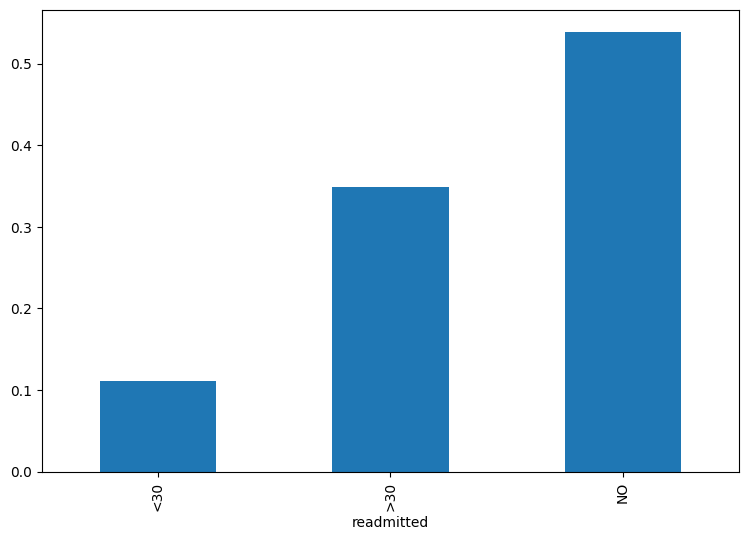

In [17]:
freqs.plot.bar(figsize=(9, 6))

The dataset is very imbalanced. Only 10% of observations represents class "readmitted within 30 days". 

## What is the distribution of gender between readmissions?

## Distribution of gender

In [18]:
data['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [19]:
freqs = data['gender'].value_counts(normalize=True)
print(freqs)

gender
Female    0.537602
Male      0.462398
Name: proportion, dtype: float64


<Axes: xlabel='gender'>

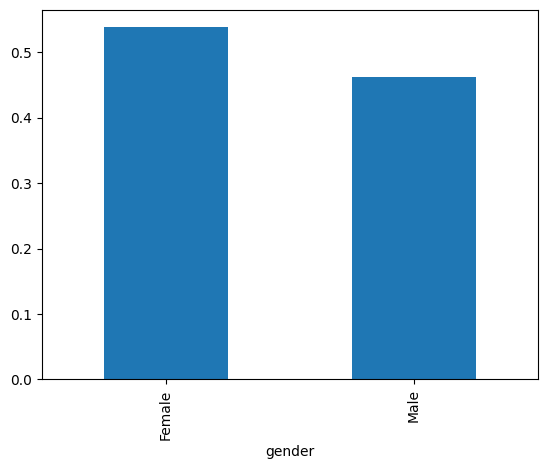

In [20]:
freqs.plot.bar()

Let's count how many patients with 'unknown/invalid' gender are there in the dataset

In [21]:
data['gender'].value_counts().sort_index()

gender
Female    54708
Male      47055
Name: count, dtype: int64

## Distribution of gender between readmissions

<Axes: xlabel='gender'>

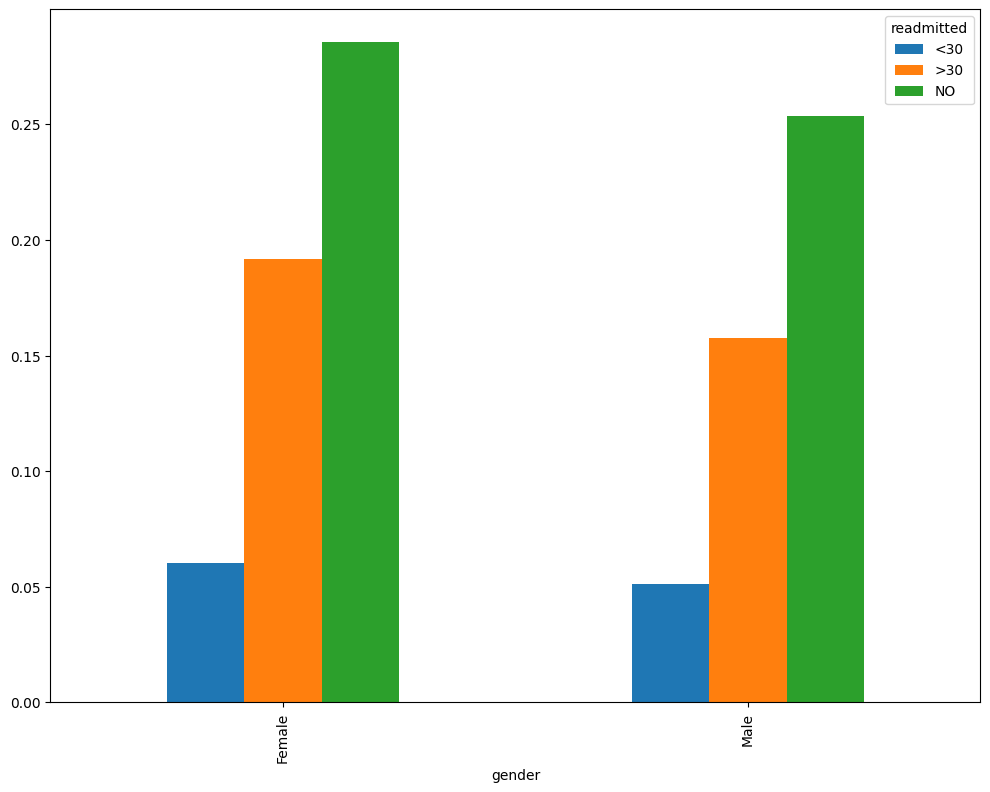

In [22]:
d = data[['gender', 'readmitted']]

cont_table = pd.crosstab(index=d['gender'], columns=data['readmitted'], normalize=True)

cont_table.plot.bar(figsize=(12, 9))

<Axes: xlabel='gender'>

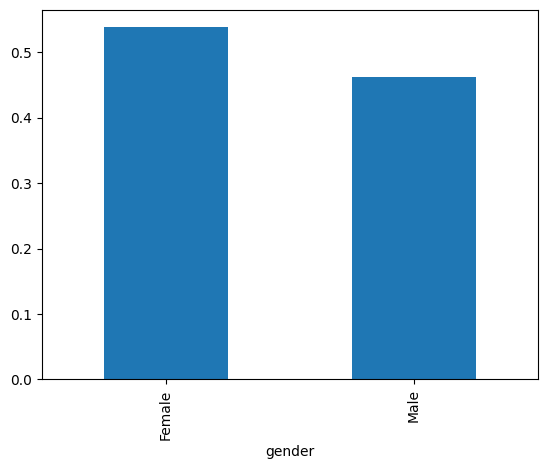

In [23]:
freqs.plot.bar()

## Distribution of age

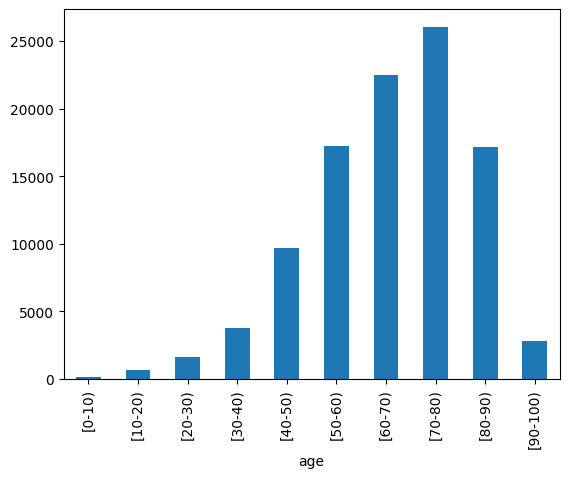

In [24]:
freqs = data['age'].value_counts().sort_index().plot.bar()

In [25]:
cont_table = pd.crosstab(index=data['age'], columns=data['readmitted'], normalize=True)
cont_table

readmitted,<30,>30,NO
age,,,
[0-10),0.000029,0.000255,0.001297
[10-20),0.000393,0.002201,0.004196
[20-30),0.002319,0.005012,0.008952
[30-40),0.004167,0.011664,0.021265
[40-50),0.010092,0.032212,0.052868
[50-60),0.016391,0.058145,0.095035
[60-70),0.024587,0.077602,0.118737
[70-80),0.030158,0.093108,0.132877
[80-90),0.020420,0.061152,0.087419


<Axes: xlabel='age'>

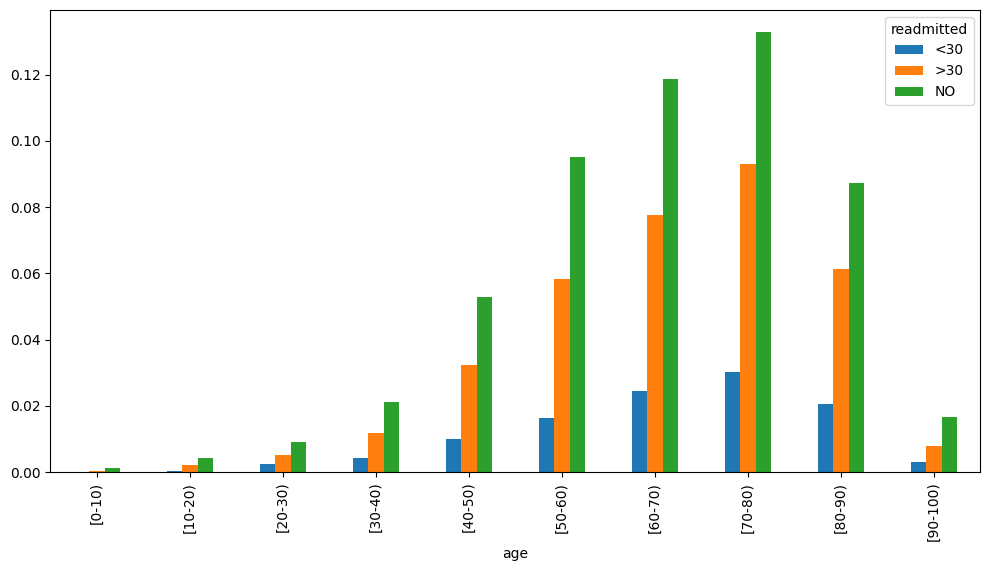

In [26]:
cont_table.plot.bar(figsize=(12, 6))

From the plot above, we can say that the distribution of age is similar between readmisssions types.

# Preparing data for further analysis

In [27]:
data.replace({'readmitted': {'NO': 0, '>30': 1, '<30': 2}}, inplace=True)

C:\Users\Raffaele\AppData\Local\Temp\ipykernel_15032\3738235945.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace({'readmitted': {'NO': 0, '>30': 1, '<30': 2}}, inplace=True)


Let's drop some variables about administrative data

In [28]:
data.drop(columns=['encounter_id', 'patient_nbr', 'race', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'examide', 'citoglipton',
                          'diag_1', 'diag_2', 'diag_3'], inplace=True)

Variables "citoglipton" and "examide" have identical values for each observations. so we need to remove them in order to build models for inferential or predictive analysis

# Inferential Analysis

## What is the average time in hospital?

In [29]:
mean = data['time_in_hospital'].mean()
print(mean)

4.396018199149003


From the results above, we find that the average time in hospital is 4 days.

<Axes: >

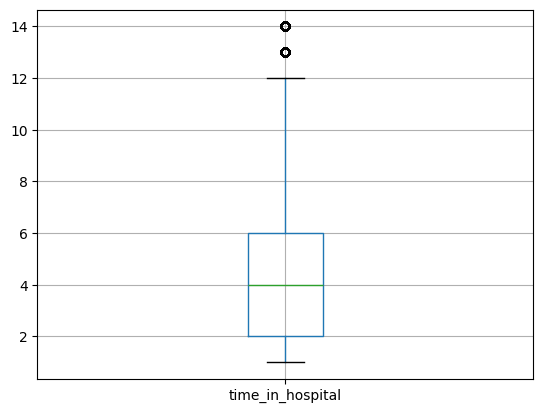

In [30]:
data.boxplot(column=['time_in_hospital'])

From the box plot above, we notice that values 13 and 14 are outliers. The median value is 4 and the third quantile is 6. 

## What is the average time in hospital between readmission classes?

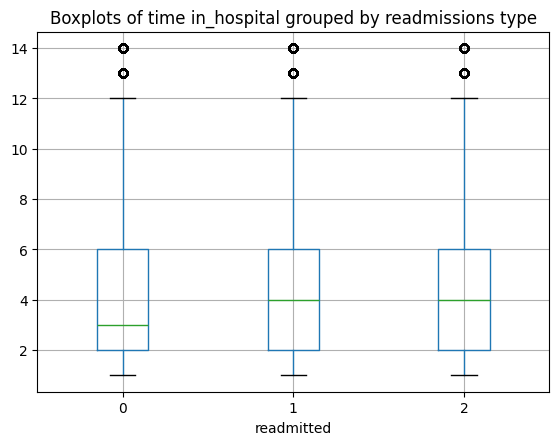

In [31]:
ax = data.boxplot(by='readmitted', column='time_in_hospital')

ax.set_title("Boxplots of time in_hospital grouped by readmissions type")
plt.suptitle("")
plt.show()

In [32]:
import seaborn as sns

<Axes: xlabel='readmitted', ylabel='time_in_hospital'>

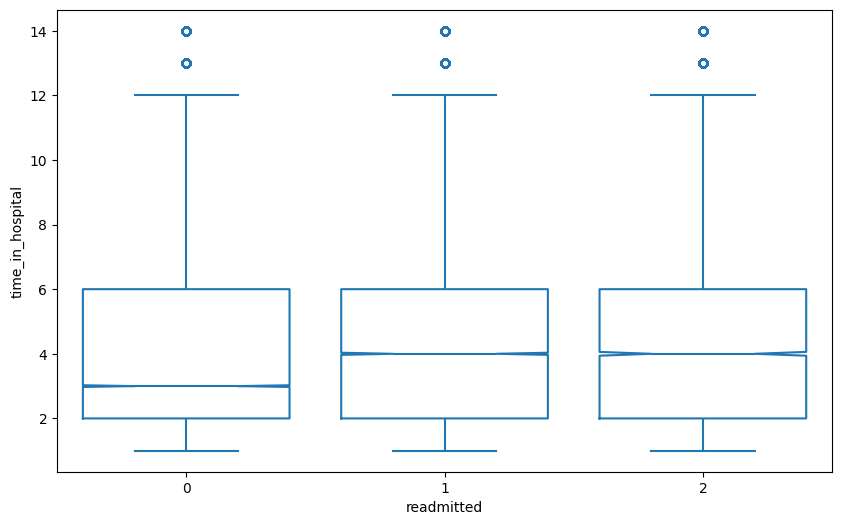

In [33]:
plt.figure(figsize=(10, 6))
sns.boxplot(data, x='readmitted', y='time_in_hospital', notch=True, fill=False)

### Average time in hospital for not-readmitted patients

In [34]:
not_readmitted = data.loc[data['readmitted'] == 0, 'time_in_hospital']
mean_not_readmitted = not_readmitted.mean()
print(mean_not_readmitted)

4.254479502743297


### Average time in hospital for readmitted patients

In [35]:
readmitted = data.loc[data['readmitted'] != 0, 'time_in_hospital']
mean_readmitted = data.loc[data['readmitted'] != 0, 'time_in_hospital'].mean()
print(mean_readmitted)

4.56157519935184


Is this due to chance or is it statistically significant? Let's run a statistical test to see if we can reject the hypothesis that the two means are equal. 

In [36]:
t, p = stats.ttest_ind(readmitted, not_readmitted)
alpha = 0.05
print("P value: ", p, "\nAlpha: ", alpha)

P value:  3.1662864432201493e-60 
Alpha:  0.05


We can reject the null hyphothesis. It is safe to say that the two populations mean are different. 

### What about the medians?

For class 0, the median is lower than the other two. This means that the distribution of time_in_hospital for patients of class 0 is not symmetrical. <br> <br> Moreover, the median for classes 1 and 2 is equal. Is this due to chance or it is statistically significant? Let's run a test to find out.

In [37]:
readmitted_within = data.loc[data['readmitted'] == 1, 'time_in_hospital']

In [38]:
readmitted_after = data.loc[data['readmitted'] == 2, 'time_in_hospital']


In [39]:
_, p = stats.kruskal(readmitted_within, readmitted_after)

print("P value: ", p, "\nAlpha: ", alpha)

P value:  1.1633727428594765e-21 
Alpha:  0.05


We can reject the null hypothesis that the two medians are equals. We can say that the two meadians actually differs.

What about the other group?

In [40]:
_, p = stats.kruskal(not_readmitted, readmitted_within)

print("P value: ", p, "\nAlpha: ", alpha)

P value:  9.590703963727032e-47 
Alpha:  0.05


In [41]:
_, p = stats.kruskal(not_readmitted, readmitted_after)

print("P value: ", p, "\nAlpha: ", alpha)

P value:  1.594974370157433e-83 
Alpha:  0.05


The three groups actually differ from each other.

## Simple logit regression

Let's fit a logistic regressor to study the relationship between time_in_hospital and readmitted. Let's see if an increase of the variable "time_in_hospital" leads to an increase in the probability that a patient will be readmitted or not. 

In [42]:
from statsmodels.formula.api import logit, mnlogit

### Preparing the data

To do this, it is not necessary to use three class of readmissions, instead it sufficient to know if a patient has been readmitted or not.

In [43]:
data['readmitted'].unique()

array([0, 1, 2])

In [44]:
data['age'].replace({'[0-10)': 5, '[10-20)': 15, '[20-30)': 25,
                             '[30-40)': 35, '[40-50)': 45, '[50-60)': 55,
                             '[60-70)': 65, '[70-80)': 75, '[80-90)': 85, '[90-100)': 95,
                            }, inplace=True)

C:\Users\Raffaele\AppData\Local\Temp\ipykernel_15032\2554642332.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['age'].replace({'[0-10)': 5, '[10-20)': 15, '[20-30)': 25,
C:\Users\Raffaele\AppData\Local\Temp\ipykernel_15032\2554642332.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data

In [45]:
view = data.replace({'readmitted': {2: 1}})

In [46]:
view['readmitted'].unique()

array([0, 1])

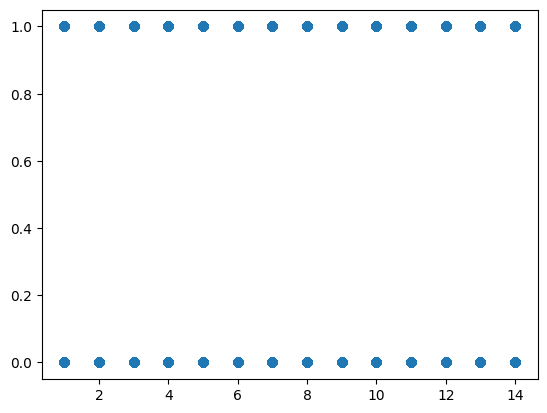

In [47]:
plt.scatter(x=view['time_in_hospital'], y=view['readmitted'])

### Simple logit regression

We can now fit a simple logit regressor

In [48]:
model = logit('readmitted ~ time_in_hospital', view).fit()

Optimization terminated successfully.
         Current function value: 0.688772
         Iterations 4


In [49]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:               101763
Model:                          Logit   Df Residuals:                   101761
Method:                           MLE   Df Model:                            1
Date:                Tue, 04 Mar 2025   Pseudo R-squ.:                0.001903
Time:                        10:37:42   Log-Likelihood:                -70092.
converged:                       True   LL-Null:                       -70225.
Covariance Type:            nonrobust   LLR p-value:                 4.513e-60
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.3084      0.011    -27.461      0.000      -0.330      -0.286
time_in_hospital     0.0344      0.002     16.331      0.000       0.030       0.039
====================================================================================
"""

The pseudo-R^2 is very small: the model do not explain well the data.

In [50]:
np.exp(-0.3085)

np.float64(0.7345479521991701)

when time_in_hospital is set to 0, unrealistically, the odds of a patient being readmitted rather than not is 0.73. 

In [51]:
np.exp(0.0344)

np.float64(1.0349985233486143)

Without considering other variables, an extra day in hospital corresponds to a multiplicative increase in the odds of a patient being readmitted rather than not of 1.034. That is, if a patient spend an extra day in the hospital, the odds of being readmitted increases by a (1-1.034)*100 = 3.4%

## Simple multivariate logit regressor

In [52]:
model = mnlogit('readmitted ~ time_in_hospital', data).fit()

Optimization terminated successfully.
         Current function value: 0.943567
         Iterations 6


In [53]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:             readmitted   No. Observations:               101763
Model:                        MNLogit   Df Residuals:                   101759
Method:                           MLE   Df Model:                            2
Date:                Tue, 04 Mar 2025   Pseudo R-squ.:                0.001736
Time:                        10:37:45   Log-Likelihood:                -96020.
converged:                       True   LL-Null:                       -96187.
Covariance Type:            nonrobust   LLR p-value:                 3.001e-73
====================================================================================
    readmitted=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.5537      0.012    -45.590      0.000      -0.577      -0.530
time_in_hospital     0.0274      0.002     11.964      0.000       0.023       0.032
------------------------------------------------------------------------------------
    readmitted=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -1.8253      0.019    -98.340      0.000      -1.862      -1.789
time_in_hospital     0.0556      0.003     16.817      0.000       0.049       0.062
====================================================================================
"""

In [54]:
np.exp(0.0556)

np.float64(1.0571747292596514)

This model only explains 0.0017% of variability in the data! Let's build a more complex models involving the other variables.

## Multiple logistic regression

In [55]:
view = data.replace({'readmitted': 2}, 1)

We need to introduce dummy variables for each categorical variable in order to build a logit regressor

In [56]:
cols = np.concatenate([[view.columns[0]], view.columns[10:-1]])
view = pd.get_dummies(view, columns=cols, drop_first=True, dtype=np.uint8)

In [57]:
cols

array(['gender', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone',
       'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide_metformin', 'glipizide_metformin',
       'glimepiride_pioglitazone', 'metformin_rosiglitazone',
       'metformin_pioglitazone', 'change', 'diabetesMed'], dtype=object)

## Removing correlated categorical variables using Cramer's V statistic

There are variables correleated with each other. To remove them, let's compute V-Cramer statistic to find these variables and remove them from the model

In [58]:
from scipy.stats.contingency import association

In [59]:
def buildVMatrix(df):
    l = []
    cat_vars = df.select_dtypes(include=['uint8']).columns
    v_mat = pd.DataFrame(index = cat_vars, columns= cat_vars)

    for var_one in cat_vars:
        for var_two in cat_vars:
            v = association(pd.crosstab(view[var_one], view[var_two]))
            v_mat.loc[var_one, var_two] = v
            
            if var_one != var_two and v >= 0.9:
                el = [var_one, var_two]
                el.sort()
                
                #usare un set
                if el[1] not in l:
                    l.append(el[1])
    return l
            

lasso + togliere variabili

In [60]:
vars_to_drop = buildVMatrix(view)
view = view.drop(columns=vars_to_drop)

## Building the model

In [61]:
import statsmodels.api as sm

exog = view.drop(columns='readmitted')
exog = sm.add_constant(exog)
endog = view['readmitted']

In [62]:
model = sm.Logit(endog, exog).fit()

         Current function value: 0.652383
         Iterations: 35


c:\Users\Raffaele\miniconda3\envs\fad\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [63]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:               101763
Model:                          Logit   Df Residuals:                   101714
Method:                           MLE   Df Model:                           48
Date:                Tue, 04 Mar 2025   Pseudo R-squ.:                 0.05463
Time:                        10:38:41   Log-Likelihood:                -66388.
converged:                      False   LL-Null:                       -70225.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               0.1595      0.481      0.332      0.740      -0.782       1.101
age                                 0.0023      0.000      5.201      0.000       0.001       0.003
time_in_hospital                    0.0113      0.003      4.399      0.000       0.006       0.016
num_lab_procedures                  0.0015      0.000      4.136      0.000       0.001       0.002
num_procedures                     -0.0455      0.004    -10.693      0.000      -0.054      -0.037
num_medications                     0.0005      0.001      0.495      0.621      -0.002       0.003
number_outpatient                   0.0824      0.006     13.713      0.000       0.071       0.094
number_emergency                    0.2172      0.012     17.667      0.000       0.193       0.241
number_inpatient                    0.3694      0.007     53.247      0.000       0.356       0.383
number_diagnoses                    0.0782      0.004     21.045      0.000       0.071       0.086
gender_Male                        -0.0487      0.013     -3.694      0.000      -0.075      -0.023
metformin_No                        0.1267      0.020      6.199      0.000       0.087       0.167
metformin_Up                       -0.0648      0.066     -0.985      0.325      -0.194       0.064
repaglinide_No                     -0.1774      0.056     -3.140      0.002      -0.288      -0.067
repaglinide_Up                     -0.2996      0.204     -1.467      0.142      -0.700       0.101
nateglinide_No                     -0.0429      0.080     -0.537      0.592      -0.200       0.114
nateglinide_Up                     -0.2787      0.441     -0.632      0.528      -1.143       0.586
chlorpropamide_No                  -0.0247      0.230     -0.107      0.915      -0.476       0.427
chlorpropamide_Up                   1.6831      1.126      1.495      0.135      -0.524       3.890
glimepiride_No                     -0.0155      0.033     -0.473      0.636      -0.080       0.049
glimepiride_Up                     -0.1806      0.119     -1.519      0.129      -0.413       0.052
acetohexamide_Steady               19.6285   1.58e+04      0.001      0.999    -3.1e+04    3.11e+04
glipizide_No                       -0.0889      0.024     -3.691      0.000      -0.136      -0.042
glipizide_Up                        0.0630      0.077      0.822      0.411      -0.087       0.213
glyburide_No                       -0.0142      0.026     -0.544      0.586      -0.065       0.037
glyburide_Up                       -0.0535      0.076     -0.706      0.480      -0.202       0.095
tolbutamide_Steady                 -0.4454      0.444     -1.004      0.315      -1.315       0.424
pioglitazone_No                    -0.0666      0.028     -2.422      0.015      -0.121      -0.013
pioglitazone_Up                     0.1439      0.137      1.052      0.293      -0.124       0.412
rosiglitazone_No                   -0.121

We have many variables with a high p-value. Let's build a better model with backwward selection

## Backward selection

In [ ]:
import warnings
warnings.simplefilter('ignore')

In [ ]:
view_bs = view
model_og = model

ll_values = [model_og.llf]
rsqr_values = [model_og.prsquared]



a = 0.05 #significance level
count = 1
while True:
    p = np.max(model.pvalues)
    i = np.argmax(model.pvalues)

    #toglierlo
    if i == 'cost' and p > a:
        exog = view_bs.drop(columns='readmitted')
        model = sm.Logit(endog, exog).fit()
        count = count + 1

        ll_values.append(model.llf)
        rsqr_values.append(model.prsquared)
        
    if p > a:
        count = count + 1
        exog = exog.drop(columns=model.pvalues.index[i])
        model = sm.Logit(endog, exog).fit()
        
        ll_values.append(model.llf)
        rsqr_values.append(model.prsquared)
        
    else:
        break
    
print(count, "variables removed")

         Current function value: 0.652395
         Iterations: 35
         Current function value: 0.652403
         Iterations: 35
         Current function value: 0.652410
         Iterations: 35
         Current function value: 0.652416
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.652420
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.652420
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.652420
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.652421
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.652422
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.652423
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.652424
         Iterations 6
Optimization terminate

In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:               101763
Model:                          Logit   Df Residuals:                   101742
Method:                           MLE   Df Model:                           20
Date:                Mon, 03 Mar 2025   Pseudo R-squ.:                 0.05443
Time:                        15:28:40   Log-Likelihood:                -66403.
converged:                       True   LL-Null:                       -70225.
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
age                    0.0023      0.000      5.221      0.000       0.001       0.003
time_in_hospital       0.0117      0.002      4.866      0.000       0.007       0.016
num_lab_procedures     0.0015      0.000      4.187      0.000       0.001       0.002
num_procedures        -0.0447      0.004    -11.309      0.000      -0.052      -0.037
number_outpatient      0.0824      0.006     13.736      0.000       0.071       0.094
number_emergency       0.2169      0.012     17.656      0.000       0.193       0.241
number_inpatient       0.3696      0.007     53.344      0.000       0.356       0.383
number_diagnoses       0.0785      0.004     21.442      0.000       0.071       0.086
gender_Male           -0.0488      0.013     -3.711      0.000      -0.075      -0.023
metformin_No           0.1364      0.018      7.728      0.000       0.102       0.171
repaglinide_No        -0.1502      0.053     -2.820      0.005      -0.255      -0.046
glipizide_No          -0.0854      0.020     -4.179      0.000      -0.125      -0.045
pioglitazone_No       -0.0668      0.026     -2.616      0.009      -0.117      -0.017
rosiglitazone_No      -0.1166      0.028     -4.236      0.000      -0.170      -0.063
rosiglitazone_Up      -0.4160      0.160     -2.594      0.009      -0.730      -0.102
acarbose_No           -0.4128      0.114     -3.608      0.000      -0.637      -0.189
miglitol_No           -0.6472      0.138     -4.676      0.000      -0.919      -0.376
insulin_No            -0.0705      0.024     -2.916      0.004      -0.118      -0.023
insulin_Steady        -0.1983      0.022     -8.869      0.000      -0.242      -0.154
insulin_Up            -0.0688      0.027     -2.531      0.011      -0.122      -0.016
diabetesMed_Yes        0.3011      0.022     13.814      0.000       0.258       0.344
======================================================================================
"""

The model does not have an intercept anymore and number_inpatient is the variable with the highest coefficient. However, the model has a very low pseudo r-squared. Let's plot the effect of backward selection on that statistic.

Text(0.5, 1.0, 'Variation in pseudo r-squared as a function of the number of variables removed')

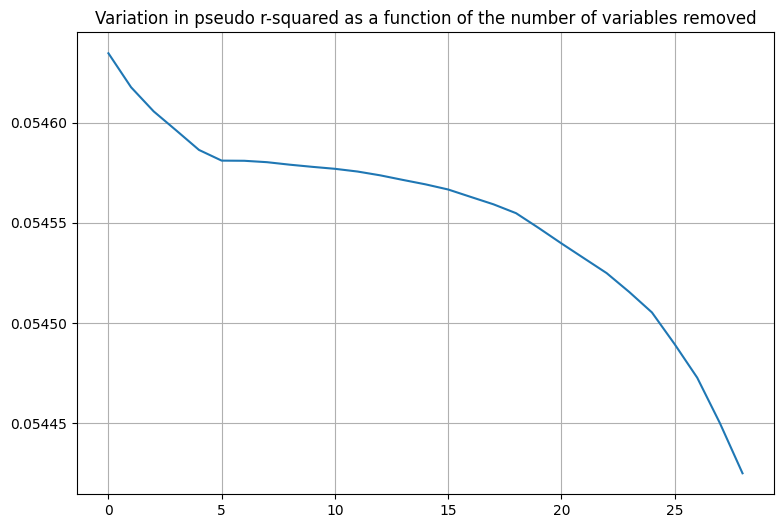

In [ ]:
plt.figure(figsize=(9, 6))
plt.plot(range(0, count), rsqr_values)
plt.grid()
plt.title("Variation in pseudo r-squared as a function of the number of variables removed")

The pseudo r-squared has slightly decreased: from 0.5463 to 0.05443 << 1. <br>


### Using Lasso regression for variable selection

It seems that there isn't a way to obtain a good pseudo r-squared. Only 0.05% of the variability in the data is explained by our model! So we can say that the logistic regression is not a good model to explain the data.

# Predictive Analysis

In this section we will create some classifiers to make predictions about data. We have a target, readmitted, with 3 classes: 
* not readmitted (0)
* readmitted within 30 days (1)
* readmitted after 30 days (2)

However, class 2 is only represented by 10% of the observations. The data has clearly an inbalance problem. At first, before being more specific, we can classify a patient in two classes: either, a patient will be readmitted (sooner or later) or not.
 

In [ ]:
view = data.replace({"readmitted": {2: 1}})

<Axes: xlabel='readmitted'>

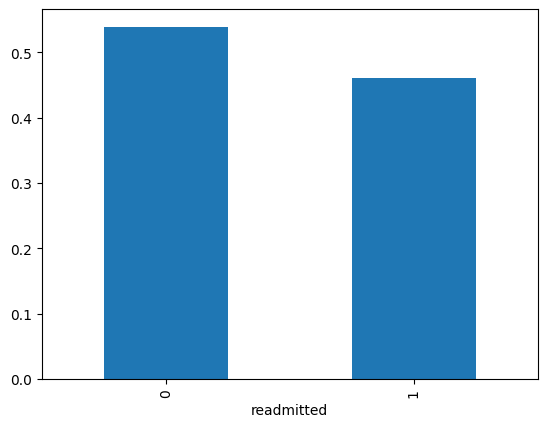

In [ ]:
view['readmitted'].value_counts(normalize=True).sort_index().plot.bar()

Classes now look more balanced.

## Which metric is more important, precision or recall?

In [ ]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

In this context, false negatives are more important than false positives. In fact, if we say that a patient will be readmitted sooner or later even if he or she is wrong, a later test in the hospital will correct our prediction. If, on the other hand, we say that a patient will not be readmitted even if he or she is wrong, we may risk the patient's life. We can say that **in this context recall is more important than precision**.

## K-Nearest Neighbor classification

In [ ]:
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split


In [ ]:
cols = np.concatenate([[view.columns[0]], view.columns[9:-1]])
view = pd.get_dummies(view, columns=cols, drop_first=True, dtype=np.uint8)

In [ ]:
train_set, test_set = train_test_split(view, test_size=0.25)

In [ ]:
train_set['readmitted']

99237    0
35366    0
99934    1
50010    0
58515    0
        ..
70402    1
29159    0
59250    0
56725    1
57678    1
Name: readmitted, Length: 76322, dtype: int64

In [ ]:
print(len(train_set), len(test_set))

76322 25441


### Hyperparameter selection using K-fold cross validation

In [ ]:
kf = KFold(n_splits=5, shuffle=True)

param_grid = [ {'n_neighbors':range(1, 10)}]

gs = GridSearchCV(KNN(), param_grid, cv=kf, scoring='recall', n_jobs=-1, refit=True)

gs.fit(X=train_set.drop(columns='readmitted'), y=train_set['readmitted'])

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid=[{'n_neighbors': range(1, 10)}], scoring='recall')

#f1 sbilanciato valore es 2 per beta

In [ ]:
gs.best_params_

{'n_neighbors': 1}

In [ ]:
knn = gs.best_estimator_  

In [ ]:
preds = knn.predict(X=test_set.drop(columns='readmitted'))

In [ ]:
recall_score(y_true=test_set['readmitted'], y_pred=preds)

0.4863224482817576

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix(y_pred=preds, y_true=test_set['readmitted'])

array([[8089, 5654],
       [6009, 5689]])

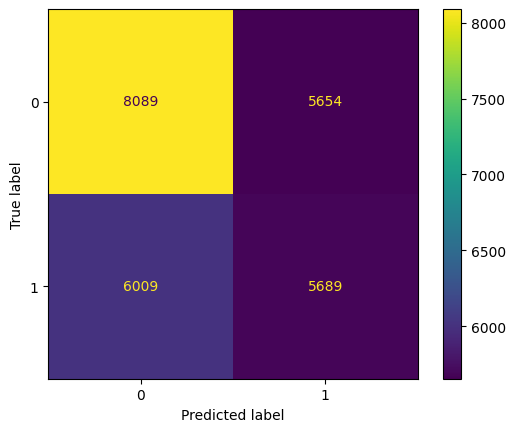

In [ ]:

ConfusionMatrixDisplay(confusion_matrix=np.array([[8089, 5654],[6009, 5689]]), display_labels=[0, 1]).plot()

In [ ]:
print("Recall: ", recall_score(y_true=test_set['readmitted'], y_pred=preds))
print("Precision: ", precision_score(y_true=test_set['readmitted'], y_pred=preds))
print("F1: ", f1_score(y_true=test_set['readmitted'], y_pred=preds))
print("Accuracy: ", accuracy_score(y_true=test_set['readmitted'], y_pred=preds))

Recall:  0.4863224482817576
Precision:  0.501542801727938
F1:  0.4938153725966755
Accuracy:  0.5415667623128022


In [ ]:
best_params = gs.cv_results_['params']
print(best_params)


[{'n_neighbors': 1}, {'n_neighbors': 2}, {'n_neighbors': 3}, {'n_neighbors': 4}, {'n_neighbors': 5}, {'n_neighbors': 6}, {'n_neighbors': 7}, {'n_neighbors': 8}, {'n_neighbors': 9}]


## Naive Bayes

# LDA 
# qda 
# principal component regression

poche componenti, espansione polinomiale, regressione logistica non lineare 


# MLP

# Conclusions